# MATLAB objective function

In [11]:
# Create a MATLAB session
# You need to specify the root folder of your MATLAB installation.
# Type matlabroot in a MATLAB session to see what the root folder is
# 
# Newer versions of MATLAB (R2014b or later) comes with an engine for Python

import matlab_wrapper
matlab = matlab_wrapper.MatlabSession(matlab_root='/Applications/MATLAB_R2014a.app', options='-nojvm')

## Define an optimization problem that calls a MATLAB objective function 

In [12]:
# This is the path to the external MATLAB function, assuming it is in your current path
import os
mfile_location = os.getcwd()
matlab.workspace.addpath(mfile_location)

class AckleyExt:
    def __init__(self, dim=10):
        self.xlow = -15 * np.ones(dim)
        self.xup = 20 * np.ones(dim)
        self.dim = dim
        self.info = str(dim) + "-dimensional Ackley function \n" + \
            "Global optimum: f(0,0,...,0) = 0"
        self.min = 0
        self.integer = []
        self.continuous = np.arange(0, dim)

    def objfunction(self, x):
        matlab.put('x', x)
        matlab.eval('matlab_ackley')
        val = matlab.get('val')
        return val
    
# The following is specified in matlab_ackley.m
#
# dim = length(x);
# val = -20*exp(-0.2*sqrt(sum(x.^2,2)/dim)) - ...
#    exp(sum(cos(2*pi*x),2)/dim) + 20 + exp(1);

## Define an optimization problem that calls a MATLAB objective function 

In [13]:
# Import the necessary modules
from pySOT import *
from poap.controller import SerialController, BasicWorkerThread
import numpy as np

maxeval = 500

data = AckleyExt(dim=10)
print(data.info)

# Use the serial controller for simplicity
# In order to run in parallel we need to maintain an array of MATLAB session
controller = SerialController(data.objfunction)
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=1,
        exp_design=LatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail, maxp=maxeval),
        sampling_method=CandidateDYCORS(data=data, numcand=100*data.dim))

# Run the optimization strategy
result = controller.run()

# Print the final result
print('Best value found: {0}'.format(result.value))
print('Best solution found: {0}'.format(
    np.array_str(result.params[0], max_line_width=np.inf,
                 precision=5, suppress_small=True)))

10-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0
Best value found: 0.0169859989031
Best solution found: [-0.00605 -0.00205 -0.00324 -0.00635 -0.00145  0.00598  0.0014   0.00438 -0.00077 -0.00335]


## Plot the progress

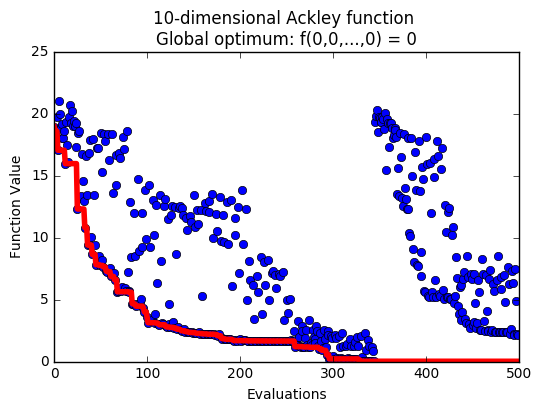

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Extract function values from the controller
fvals = np.array([o.value for o in controller.fevals])

f, ax = plt.subplots()
ax.plot(np.arange(0,maxeval), fvals, 'bo')  # Points
ax.plot(np.arange(0,maxeval), np.minimum.accumulate(fvals), 'r-', linewidth=4.0)  # Best value found
plt.xlabel('Evaluations')
plt.ylabel('Function Value')
plt.title(data.info)
plt.show()

## End the MATLAB session

In [15]:
matlab.__del__()

## Written by, David Eriksson, dme65@cornell.edu